In [1]:
## GBM = Gradient boosting machine
%cd "C:/app"

C:\app


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


sns.set(rc={'figure.figsize':(10,5)})
sns.set_theme()
sns.set_style('whitegrid')

In [3]:
from pathlib import Path
import pandas as pd

import lightgbm as lgb

In [4]:
# load data
from sklearn.preprocessing import scale


data = pd.read_csv("./data/boosting/features_targets.csv", index_col="Timestamp", parse_dates=["Timestamp"])
data


excluded_cols = ['Open',
 'High',
 'Low',
 'Close',
 'Symbol']

all_cols = [c for c in data.columns if c not in excluded_cols ]
data = data[all_cols]

data.loc[:, data.columns] = scale(data)

features_cols = data.columns[data.columns.str.contains("TARGET") == False]
features = data[features_cols]
features.describe()

target_col = "TARGET_LOGRET_5"
targets = data[[target_col]]
targets.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24410 entries, 2021-01-18 10:00:00 to 2022-12-30 20:30:00
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TARGET_LOGRET_5  24410 non-null  float64
dtypes: float64(1)
memory usage: 381.4 KB


**Simple Playaround**

In [5]:
# package: lightgbm
# github of package: https://github.com/microsoft/LightGBM
# import lightgbm as lgb

# prepare data
size = 1000
target_col = "TARGET_LOGRET_5"
y = targets[[target_col]].head(size)
X = features.head(size)

# train test split
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)


#### train
# list of params: https://lightgbm.readthedocs.io/en/latest/Parameters.html
# no cross validation
lgb_train = lgb.Dataset(data=X_train,
                   label=y_train,
                   free_raw_data=False # it is to release memory and only using it when training (if True you cant see data)
                   )

lgb_valid = lgb.Dataset(data=X_valid,
                   label=y_valid,
                   free_raw_data=False)
 
params = { 
    "objective": "regression",
    "metric": ('l1', 'l2'), # mean absolute error, and mean squared error
    
    "num_iterations": 10, # alias for numbef of trees
    # "learning_rate": 0.01, # it is for the contribution of each tree to final result and find the best W s
    
    "max_depth": 5,
    "num_leaves": 10,
    "min_data_in_leaf": 5,
    "feature_fraction": 0.3,
}

evals_result = {}

model = lgb.train(params=params,
                  train_set=lgb_train,
                  valid_sets=[lgb_valid, lgb_train],
                  callbacks=[
                    lgb.log_evaluation(10),
                    lgb.record_evaluation(evals_result),
                    lgb.early_stopping(stopping_rounds=5)
                ]
)


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6118
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 24
[LightGBM] [Info] Start training from score 0.045937
Training until validation scores don't improve for 5 rounds
[10]	training's l1: 0.381035	training's l2: 0.258295	valid_0's l1: 0.430997	valid_0's l2: 0.315301
Did not meet early stopping. Best iteration is:
[10]	training's l1: 0.381035	training's l2: 0.258295	valid_0's l1: 0.430997	valid_0's l2: 0.315301


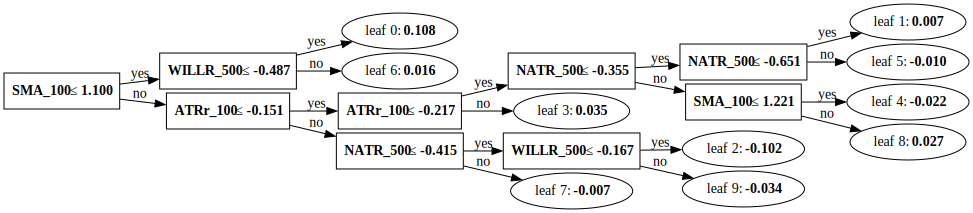

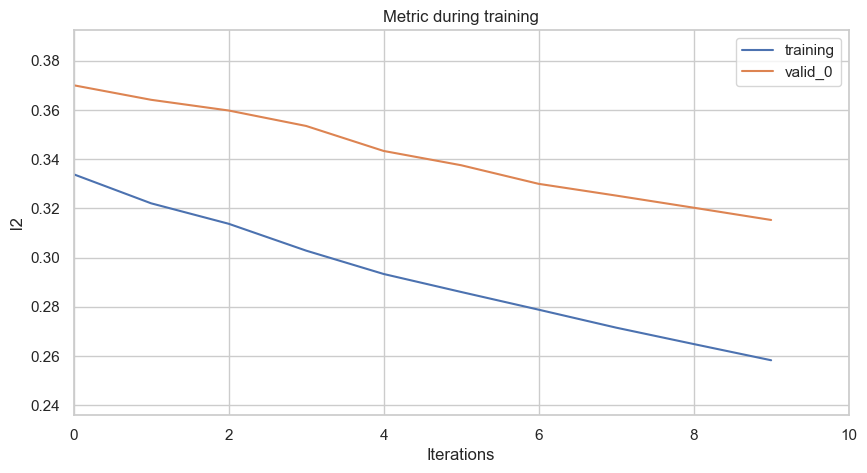

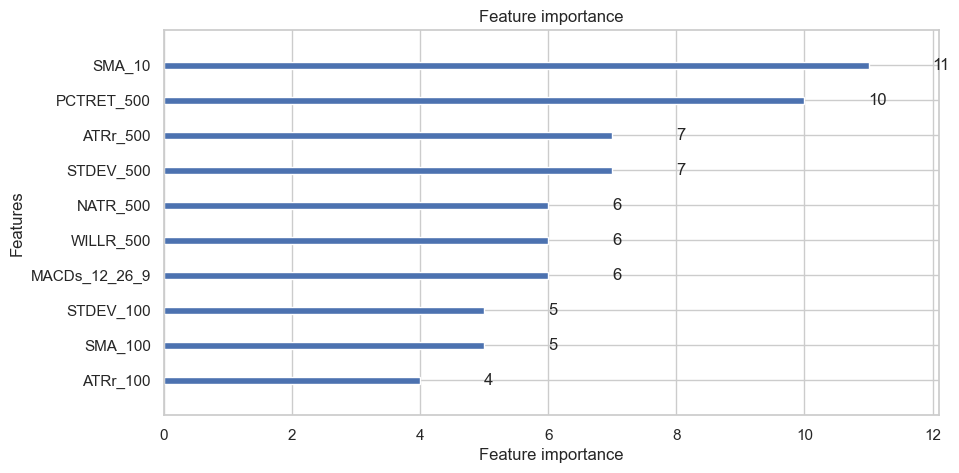

In [6]:
# plotting
# plotting: https://github.com/microsoft/LightGBM/blob/master/examples/python-guide/plot_example.py
lgb.plot_metric(evals_result, metric='l2')
lgb.plot_importance(model, max_num_features=10)

# lgb.plot_split_value_histogram(model, feature='STDEV_500', bins='auto') ???

lgb.create_tree_digraph(model, tree_index=2, name='Tree2')

In [7]:
# prediction
from sklearn.metrics import mean_squared_error
y_preds = model.predict(X)
mean_squared_error(y, y_preds) ** 0.5

0.5193224258842907

**Cross Validation**

In [8]:
params = { 
        "objective": "regression",
        "metric": ('l1', 'l2'),
    
        "learning_rate": 0.01,
        "num_iterations": 50,
        
        "max_depth": 5,
        "num_leaves": 10,
        "min_data_in_leaf": 5,
        "feature_fraction": 0.3,

        'verbose': -1
    }

In [9]:
from sklearn.model_selection import TimeSeriesSplit


target_col = "TARGET_LOGRET_5"
y = targets[[target_col]].head(2000)
X = features.head(2000)

train_length=1000
test_length=100
size = len(X)
n_splits = int((size -1) / test_length)

cv = TimeSeriesSplit(
            max_train_size=train_length, 
            test_size=test_length,
            n_splits=n_splits
        );

In [10]:
lgb_data = lgb.Dataset(data=X,
                       label=y,
                       free_raw_data=False)
predictions = []

for train_idx, test_idx in cv.split(X):
    
    if len(train_idx) < train_length:
        continue;

    print("-" * 50)
    print(f"train len: {min( train_idx)} to {max( train_idx)}")
    print(f"test len: {min( test_idx)} to {max( test_idx)}")
    
    train_ds = lgb_data.subset(used_indices=train_idx.tolist())
    
    
    print("start training")
    model = lgb.train(params=params,
                      train_set=train_ds,
    )


    test_x = X.iloc[test_idx,:]
    test_y = y.iloc[test_idx,:]

    test_preds = model.predict(test_x)
    test_preds_df = pd.DataFrame(test_preds, index=test_y.index, columns=["Prediction"])
    predictions.append(test_preds_df) 
    
predictions_df = pd.concat(predictions) 

--------------------------------------------------
train len: 0 to 999
test len: 1000 to 1099
start training
--------------------------------------------------
train len: 100 to 1099
test len: 1100 to 1199
start training
--------------------------------------------------
train len: 200 to 1199
test len: 1200 to 1299
start training
--------------------------------------------------
train len: 300 to 1299
test len: 1300 to 1399
start training
--------------------------------------------------
train len: 400 to 1399
test len: 1400 to 1499
start training
--------------------------------------------------
train len: 500 to 1499
test len: 1500 to 1599
start training
--------------------------------------------------
train len: 600 to 1599
test len: 1600 to 1699
start training
--------------------------------------------------
train len: 700 to 1699
test len: 1700 to 1799
start training
--------------------------------------------------
train len: 800 to 1799
test len: 1800 to 1899
start trai

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000 entries, 2021-02-16 06:00:00 to 2021-03-17 01:30:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Prediction  1000 non-null   float64
dtypes: float64(1)
memory usage: 15.6 KB


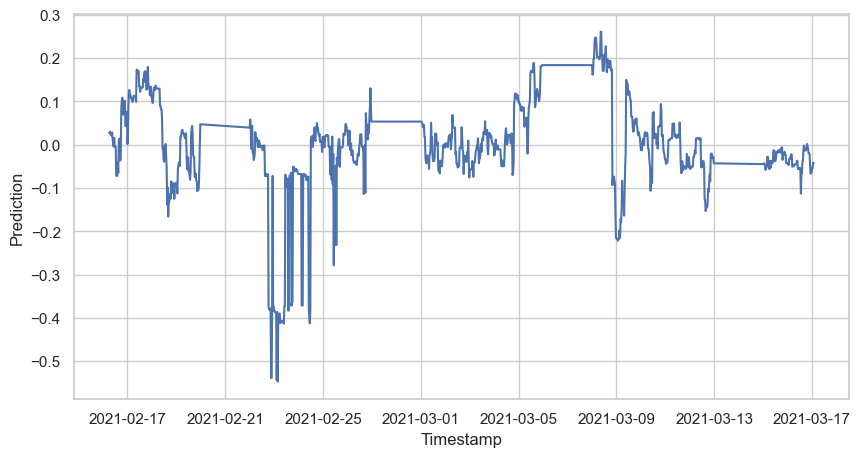

In [11]:
sns.lineplot(x="Timestamp", y="Prediction",data=predictions_df)
predictions_df.info()

In [12]:
# save
predictions_df.to_csv("./data/boosting/predictions")